In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from lifelines import KaplanMeierFitter, WeibullAFTFitter
from lifelines.statistics import logrank_test
import warnings
warnings.filterwarnings('ignore')

# set style for ploting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 8]

1/ LOAD DATA + MERGE SEMANTIC SIMILARITY SCORE

In [ ]:
# load data full
df = pd.read_csv("D:/KU Leuven/Master Thesis/Starting-over-2/Analysis/cleaning/clean/full_data.csv")
# load data semantic similarity
df_semantic = pd.read_csv("D:/KU Leuven/Master Thesis/Starting-over-2/Analysis/cleaning/clean/semantic.csv")

In [14]:
# convert date to datetime
df['scrape_date'] = pd.to_datetime(df['scrape_date'])

# data info
print(f"Dataset shape: {df.shape}")
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset shape: (1477644, 66)

Missing values per column:
Unnamed: 0       0
asin             0
search_term      0
page_number      0
position         0
                ..
tf_idf_title     0
tf_bullet        0
tf_idf_bullet    0
tf_des           0
tf_idf_des       0
Length: 66, dtype: int64


In [7]:
# merge the semantic similarity result with main data
df = pd.merge(
    df,
    df_semantic[['asin', 'semantic_title', 'semantic_bullet', 'semantic_description','tf_title',
                 'tf_idf_title','tf_bullet','tf_idf_bullet','tf_des','tf_idf_des']], 
    on='asin', 
    how='left'
)
# check the result
print(f"Total rows in full data: {len(df)}")
print(f"ASINs with semantic data: {df['semantic_title'].notna().sum()}")
print(f"ASINs without semantic data: {df['semantic_title'].isna().sum()}")
print("\nexample:")
print(df[['asin', 'semantic_title', 'semantic_bullet', 'semantic_description']].head())

Total rows in full data: 1477644
ASINs with semantic data: 1477644
ASINs without semantic data: 0

example:
         asin  semantic_title  semantic_bullet  semantic_description
0  B0D3HD4KTD        0.446643         0.354342              0.592259
1  B0CJ399BX5        0.381550         0.394805              0.403536
2  B00E3DVQFS        0.562820         0.367025              0.449279
3  B0CCR5QJYS        0.506970         0.410145              0.430287
4  B093LVB4P7        0.583688         0.357817              0.461419


In [ ]:
# remove duplicate
df = df.drop_duplicates(subset=['asin', 'search_term', 'page_number', 'position', 'scrape_date', 'scrape_hour'], keep='first')
print(df.shape)

(1477644, 66)


2/ PREPROCESSING DATA

In [15]:
# sort data by ASIN, search term, and scrape date, scrape_hour to ensure chronological order
df_sorted = df.sort_values(['asin', 'search_term', 'scrape_date', 'scrape_hour'])

# create a unique identifier for each product-search combination
df_sorted['product_search_id'] = df_sorted['asin'] + '_' + df_sorted['search_term']

# get the earliest date for each product-search combination
earliest_observations = df_sorted.groupby('product_search_id').apply(
    lambda x: x.loc[x['scrape_date'] == x['scrape_date'].min()]
).reset_index(drop=True)

# from those earliest observations, get the first rank
initial_ranks = earliest_observations.groupby('product_search_id')['continuous_rank'].first().reset_index()
initial_ranks.columns = ['product_search_id', 'initial_rank']

# merge back to the main dataframe
df_sorted = df_sorted.merge(initial_ranks, on='product_search_id', how='left')

In [24]:
# define funtion to calculate survival time
def calculate_survival_time(group):
    """longest streak prodcut stay at the same or better rank"""
    # sort by date and hour
    group = group.sort_values(['asin','search_term','page_number','scrape_date', 'scrape_hour'])
    group['datetime'] = group['scrape_date'] + pd.to_timedelta(group['scrape_hour'], unit='h')
    
    # time difference between consecutive appearances
    group['time_diff'] = group['datetime'].diff().dt.total_seconds() / 3600  # Convert to hours
    
    # reset time_diff to 0 when search_term or asin changes
    group['prev_search_term'] = group['search_term'].shift(1)
    group['prev_asin'] = group['asin'].shift(1)
    
    # set time diff to 0 for the first row of new asin/search_term
    mask = (group['search_term'] != group['prev_search_term']) | (group['asin'] != group['prev_asin'])
    group.loc[mask, 'time_diff'] = 0
    
    # fill na and negative time diff values with 0
    group['time_diff'] = group['time_diff'].fillna(0)
    group.loc[group['time_diff'] < 0, 'time_diff'] = 0
    
    # calculate rank difference between consecutive appearances
    group['rank_diff'] = group['continuous_rank'].diff()
    
    # start a new streak when rank_diff > 0 (rank increase = drop to lower rank)
    group['streak_id'] = (group['rank_diff'] > 0).cumsum()
    
    # hourly streak
    streak_lengths = group.groupby('streak_id').size()
    longest_streak_hours = streak_lengths.max() if not streak_lengths.empty else 0
    actual_hours = longest_streak_hours * 2  # Assuming 2-hour intervals
    
    # daily streak
    group['date_only'] = group['scrape_date'].dt.date
    # get number of unique days for each streak
    days_per_streak = group.groupby('streak_id')['date_only'].nunique()
    
    # find longest streak in days
    longest_streak_days = days_per_streak.max() if not days_per_streak.empty else 0
    
    return pd.Series({
        'survival_hours': actual_hours,
        'survival_days': longest_streak_days,  # Changed to use streak-based days
        'initial_rank': group['initial_rank'].iloc[0],
        'sponsored': group['sponsored'].iloc[0],
        'reviews_count': group['log_review'].iloc[0],
        'price': group['log_price'].iloc[0],
        'price_com': group['price_competitiveness'].iloc[0],
        'rating': group['rating'].iloc[0],
        'prime': group['prime'].iloc[0],
        'sales_rank_main': group['log_main_rank'].iloc[0],
        'sales_rank_sub': group['log_sub_rank'].iloc[0],
        'popularity': group['popularity'].iloc[0],
        'discount': group['discount'].iloc[0],
        'sales_badge': group['sales_badge'].iloc[0],
        # 'tf_bullet': group['tf_bullet'].iloc[0],
        # 'tf_title': group['tf_title'].iloc[0],
        # 'tf_des': group['tf_des'].iloc[0],
        # 'tf_idf_bullet': group['tf_idf_bullet'].iloc[0],
        # 'tf_idf_title': group['tf_idf_title'].iloc[0],
        # 'tf_idf_des': group['tf_idf_des'].iloc[0],
        # 'semantic_bullet': group['semantic_bullet'].iloc[0],
        # 'semantic_title': group['semantic_title'].iloc[0],
        # 'semantic_description': group['semantic_description'].iloc[0],
        'page_number':  group['page_number'].iloc[0]
    })

In [ ]:
# apply to the data set
survival_data = df_sorted.groupby('product_search_id').apply(calculate_survival_time).reset_index()

In [30]:
survival_data.head(10)

,product_search_id,survival_hours,survival_days,initial_rank,sponsored,reviews_count,price,price_com,rating,prime,sales_rank_main,sales_rank_sub,popularity,discount,sales_badge,page_number,event
0,013249115X_micro sd card,2,1,149,False,2.708050,2.718001,0.957506,3.9,True,16.118096,16.118096,False,0,0,3,1
1,035911489X_fire stick,14,2,153,False,3.178054,2.610805,0.952948,2.4,True,16.118096,16.118096,False,0,0,3,1
2,068806843X_microwave,2,1,93,False,4.276666,5.278115,0.439430,4.5,False,16.118096,16.118096,False,0,0,2,1
3,069294107X_headphones,2,1,164,False,1.386294,2.650421,0.955931,5.0,True,16.118096,16.118096,False,0,0,3,1
4,071602067X_microwave,2,1,110,False,5.552960,2.047693,0.980596,4.4,True,16.118096,16.118096,False,1,0,2,1
5,075356016X_umbrella,2,1,146,False,1.098612,3.409827,0.781625,4.5,True,13.131642,7.334329,False,0,0,3,1
6,076039122X_barbie,4,2,107,False,6.035481,2.348514,0.963077,4.7,True,12.646853,4.521789,False,0,0,2,1
7,099871402X_dog food,2,1,127,False,3.332205,2.768204,0.880903,4.1,True,16.118096,16.118096,False,0,0,3,1
8,1035904942_knife set,2,1,161,False,6.689599,2.484073,0.984210,4.4,True,12.239333,6.575076,False,1,0,3,1
9,1071168193_fire stick,12,2,171,False,1.386294,2.610805,0.949366,2.7,True,16.118096,16.118096,False,0,0,2,1


In [32]:
# create event column
# all products eventually drop off or are censored at the end of observation 
survival_data['event'] = 1

In [33]:
# Separate data for sponsored and organic products
sponsored_data = survival_data[survival_data['sponsored'] == True]
organic_data = survival_data[survival_data['sponsored'] == False]

In [34]:
# create seperate data for page
# page 1
page1_data = survival_data[survival_data['page_number'] == 1].copy()
sponsored_page1 = page1_data[page1_data['sponsored'] == True]
organic_page1 = page1_data[page1_data['sponsored'] == False]

# page 2
page2_data = survival_data[survival_data['page_number'] == 2].copy()
sponsored_page2 = page2_data[page2_data['sponsored'] == True]
organic_page2 = page2_data[page2_data['sponsored'] == False]

# page 3
page3_data = survival_data[survival_data['page_number'] == 3].copy()
sponsored_page3 = page3_data[page3_data['sponsored'] == True]
organic_page3 = page3_data[page3_data['sponsored'] == False]

In [29]:
# check statistics
# hour
hours_stats = pd.DataFrame({
    'Page 1/Sponsored': sponsored_page1['survival_hours'].describe(),
    'Page 1/Organic': organic_page1['survival_hours'].describe(),
    'Page 2/Sponsored': sponsored_page2['survival_hours'].describe(),
    'Page 2/Organic': organic_page2['survival_hours'].describe(),
    'Page 3/Sponsored': sponsored_page3['survival_hours'].describe(),
    'Page 3/Organic': organic_page3['survival_hours'].describe(),
})

# day
days_stats = pd.DataFrame({
    'Page 1/Sponsored': sponsored_page1['survival_days'].describe(),
    'Page 1/Organic': organic_page1['survival_days'].describe(),
    'Page 2/Sponsored': sponsored_page2['survival_days'].describe(),
    'Page 2/Organic': organic_page2['survival_days'].describe(),
    'Page 3/Sponsored': sponsored_page3['survival_days'].describe(),
    'Page 3/Organic': organic_page3['survival_days'].describe(),
})

print("\nSurvival hours:")
print(hours_stats.T) 
print("\nSurvival days:")
print(days_stats.T)

# save to csv for making tables
hours_stats.T.to_csv('survival_hours_statistics.csv')
days_stats.T.to_csv('survival_days_statistics.csv')


Survival hours:
                    count       mean        std  min  25%   50%   75%    max
Page 1/Sponsored   3204.0  29.818976  35.077538  2.0  6.0  16.0  36.0  164.0
Page 1/Organic    10287.0  13.320696  13.499530  2.0  8.0  10.0  14.0  164.0
Page 2/Sponsored    404.0  15.905941  28.221053  2.0  2.0   5.0  14.5  164.0
Page 2/Organic     9158.0   8.884691   4.726485  2.0  6.0  10.0  12.0  100.0
Page 3/Sponsored    109.0   2.458716   1.294805  2.0  2.0   2.0   2.0   12.0
Page 3/Organic     7580.0   6.784697   7.290158  2.0  2.0   6.0   8.0  162.0

Survival days:
                    count      mean       std  min  25%  50%  75%  max
Page 1/Sponsored   3204.0  2.915106  1.649502  1.0  2.0  3.0  4.0  7.0
Page 1/Organic    10287.0  2.051230  0.678408  1.0  2.0  2.0  2.0  7.0
Page 2/Sponsored    404.0  2.044554  1.451617  1.0  1.0  2.0  2.0  7.0
Page 2/Organic     9158.0  1.922254  0.629153  1.0  2.0  2.0  2.0  7.0
Page 3/Sponsored    109.0  1.055046  0.266488  1.0  1.0  1.0  1.0  3.0
Pa

In [31]:
survival_data[survival_data['survival_hours']==164]

,product_search_id,survival_hours,survival_days,initial_rank,sponsored,reviews_count,price,price_com,rating,prime,sales_rank_main,sales_rank_sub,popularity,discount,sales_badge,page_number,event
7395,B086MC977H_gaming chair,164,7,5,False,8.894533,4.919908,0.641187,4.4,False,6.807935,1.386294,True,0,1,1,1
8286,B08HDSGH9W_fire stick,164,7,1,True,5.181784,3.233567,0.909067,4.2,True,11.259696,6.091310,False,0,0,1,1
11270,B09L4HMYG9_fire stick,164,7,2,True,4.521789,2.174752,0.970896,4.4,True,11.905535,8.242756,False,0,0,1,1
12422,B09WZBVWL9_ring doorbell,164,7,7,False,2.564949,5.017214,0.624085,4.3,True,16.118096,16.118096,False,1,0,1,1
13634,B0B6WRFY5S_fitbit,164,7,5,False,8.798002,4.382027,0.608911,4.3,True,5.204007,1.609438,True,0,1,1,1
15694,B0BTYCRJSS_bluetooth headphones,164,7,5,False,10.680355,3.044046,0.930830,4.4,True,4.143135,2.079442,True,1,1,1,1
15696,B0BTYCRJSS_earbuds,164,7,5,False,10.680355,3.044046,0.928605,4.4,True,4.143135,2.079442,True,1,1,1,1
17430,B0C61S4JWZ_ring doorbell,164,7,1,True,3.178054,1.930071,0.985238,4.1,True,11.550375,5.192957,False,0,0,1,1
19370,B0CHRXK8G6_fitbit,164,7,57,True,4.189655,2.564180,0.940644,4.3,True,7.947679,3.258097,False,0,0,1,1
21311,B0CRP32YB7_aa batteries,164,7,21,True,6.137727,2.350422,0.862464,4.4,True,10.681940,5.880533,False,1,0,1,1


3/ PLOT THE KAPLAN-MEIER CURVES

In [35]:
# test if the difference between sponsored and organic is statistically significant
print("Log-rank test difference survival hours:")
results = logrank_test(sponsored_data['survival_hours'], organic_data['survival_hours'], 
                      event_observed_A=sponsored_data['event'], 
                      event_observed_B=organic_data['event'])
print(results.summary)

print("\nLog-rank test difference survival days:")
results = logrank_test(sponsored_data['survival_days'], organic_data['survival_days'], 
                      event_observed_A=sponsored_data['event'], 
                      event_observed_B=organic_data['event'])
print(results.summary)

Log-rank test difference survival hours:
   test_statistic    p  -log2(p)
0     2379.633353  0.0       inf

Log-rank test difference survival days:
   test_statistic    p  -log2(p)
0     1978.484689  0.0       inf


In [38]:
# set font/size for all plots
plt.rcParams.update({
    'font.size': 14,        # Base font size
    'axes.titlesize': 14,   # Title font size
    'axes.labelsize': 14,   # Axis label font size
    'legend.fontsize': 24,  # Legend font size
    'xtick.labelsize': 24,  # X-tick labels size
    'ytick.labelsize': 18   # Y-tick labels size
})

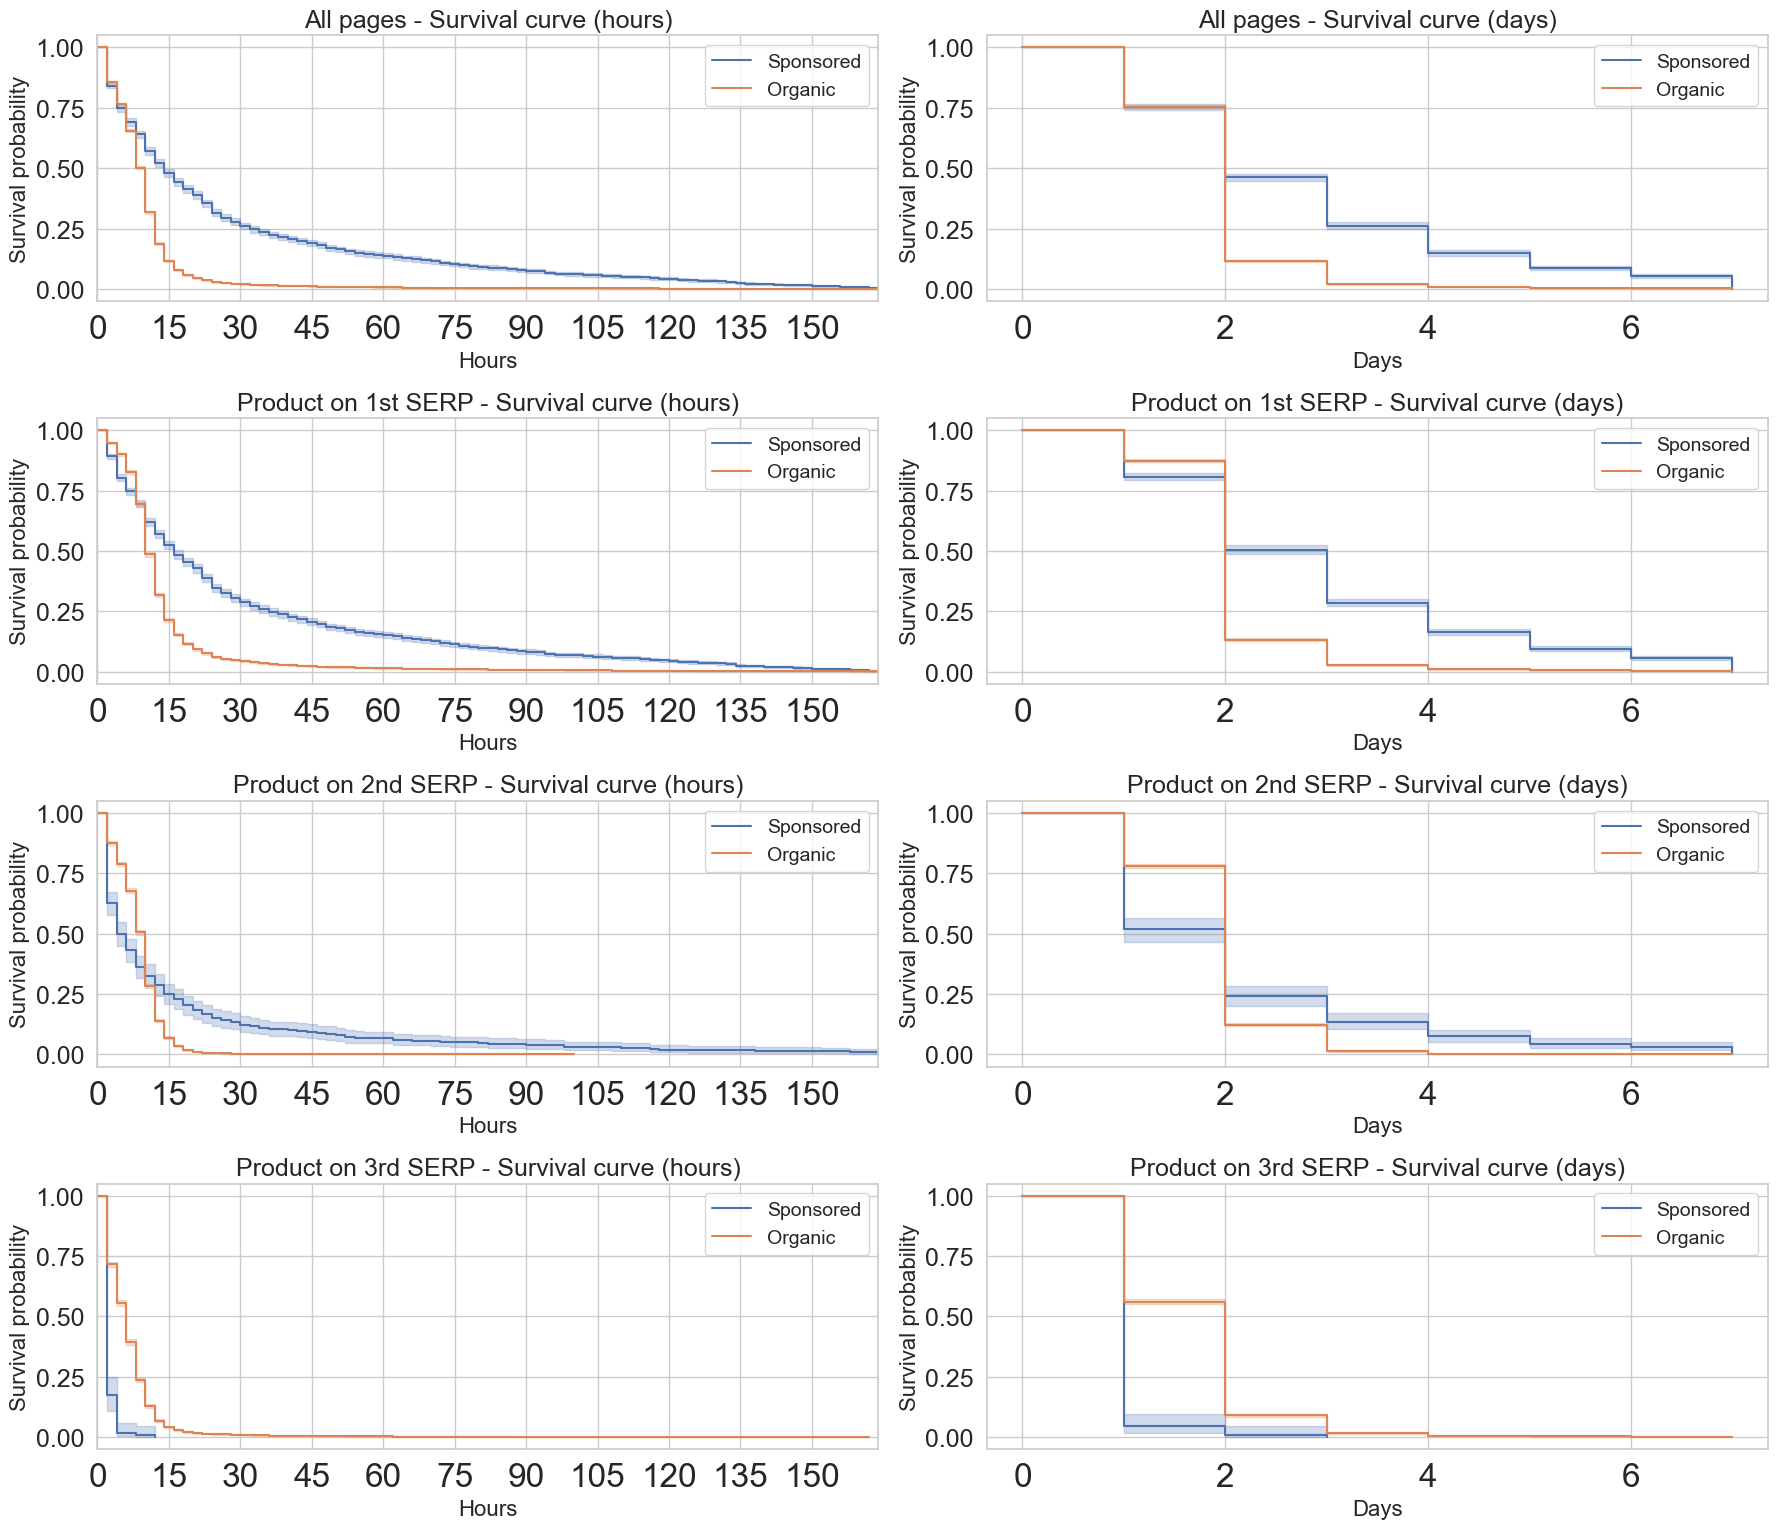

In [39]:
# make plot of 4, 1 overall, 3 per page
plt.figure(figsize=(18, 16))

# fit kaplan curves
kmf = KaplanMeierFitter()
plt.subplot(4, 2, 1)

# hourly - overall plot
# sponsored products
kmf.fit(sponsored_data['survival_hours'], event_observed=sponsored_data['event'], label='Sponsored')
ax1 = kmf.plot_survival_function()

# organic products
kmf.fit(organic_data['survival_hours'], event_observed=organic_data['event'], label='Organic')
kmf.plot_survival_function(ax=ax1)

#customize the size to fit in thesis
max_hours = 164
ax1.set_xticks(range(0, max_hours+1, 15))
ax1.set_xlim(0, max_hours)
ax1.grid(True)

plt.title('All pages - Survival curve (hours)', fontsize=18)
plt.xlabel('Hours', fontsize=16)
plt.ylabel('Survival probability', fontsize=16)
plt.legend(fontsize=14)

# Plot for daily survival (Overall)
plt.subplot(4, 2, 2)  # Changed from 3,2,2 to 4,2,2

# daily - overall plot
# sponsored products 
kmf.fit(sponsored_data['survival_days'], event_observed=sponsored_data['event'], label='Sponsored')
ax2 = kmf.plot_survival_function()
# organic
kmf.fit(organic_data['survival_days'], event_observed=organic_data['event'], label='Organic')
kmf.plot_survival_function(ax=ax2)
plt.title('All pages - Survival curve (days)', fontsize=18)
plt.xlabel('Days', fontsize=16)
plt.ylabel('Survival probability', fontsize=16)
plt.legend(fontsize=14)


#-------- per-page -------------

# page 1 - hourly
plt.subplot(4, 2, 3)

# sponsored products 
kmf.fit(sponsored_page1['survival_hours'], event_observed=sponsored_page1['event'], label='Sponsored')
ax3 = kmf.plot_survival_function()

# organic
kmf.fit(organic_page1['survival_hours'], event_observed=organic_page1['event'], label='Organic')
kmf.plot_survival_function(ax=ax3)

ax3.set_xticks(range(0, max_hours+1, 15))
ax3.set_xlim(0, max_hours)
ax3.grid(True)

plt.title('Product on 1st SERP - Survival curve (hours)', fontsize=18)
plt.xlabel('Hours', fontsize=16)
plt.ylabel('Survival probability', fontsize=16)
plt.legend(fontsize=14)

# page 1 - daily
plt.subplot(4, 2, 4)  # Changed from 3,2,4 to 4,2,4

# sponsored products 
kmf.fit(sponsored_page1['survival_days'], event_observed=sponsored_page1['event'], label='Sponsored')
ax4 = kmf.plot_survival_function()

# organic
kmf.fit(organic_page1['survival_days'], event_observed=organic_page1['event'], label='Organic')
kmf.plot_survival_function(ax=ax4)

plt.title('Product on 1st SERP - Survival curve (days)', fontsize=18)
plt.xlabel('Days', fontsize=16)
plt.ylabel('Survival probability', fontsize=16)
plt.legend(fontsize=14)

# page 2 - hourly
plt.subplot(4, 2, 5)

# sponsored products 
kmf.fit(sponsored_page2['survival_hours'], event_observed=sponsored_page2['event'], label='Sponsored')
ax5 = kmf.plot_survival_function()

# organic
kmf.fit(organic_page2['survival_hours'], event_observed=organic_page2['event'], label='Organic')
kmf.plot_survival_function(ax=ax5)

ax5.set_xticks(range(0, max_hours+1, 15))
ax5.set_xlim(0, max_hours)
ax5.grid(True)

plt.title('Product on 2nd SERP - Survival curve (hours)', fontsize=18)
plt.xlabel('Hours', fontsize=16)
plt.ylabel('Survival probability', fontsize=16)
plt.legend(fontsize=14)

# page 2 - daily
plt.subplot(4, 2, 6)

# sponsored products 
kmf.fit(sponsored_page2['survival_days'], event_observed=sponsored_page2['event'], label='Sponsored')
ax6 = kmf.plot_survival_function()

# organic
kmf.fit(organic_page2['survival_days'], event_observed=organic_page2['event'], label='Organic')
kmf.plot_survival_function(ax=ax6)

plt.title('Product on 2nd SERP - Survival curve (days)', fontsize=18)
plt.xlabel('Days', fontsize=16)
plt.ylabel('Survival probability', fontsize=16)
plt.legend(fontsize=14)

# page 3 - hourly
plt.subplot(4, 2, 7)  # Keep as 4,2,7 for the last two plots

# sponsored products
kmf.fit(sponsored_page3['survival_hours'], event_observed=sponsored_page3['event'], label='Sponsored')
ax7 = kmf.plot_survival_function()

# organic
kmf.fit(organic_page3['survival_hours'], event_observed=organic_page3['event'], label='Organic')
kmf.plot_survival_function(ax=ax7)

ax7.set_xticks(range(0, max_hours+1, 15))
ax7.set_xlim(0, max_hours)
ax7.grid(True)

plt.title('Product on 3rd SERP - Survival curve (hours)', fontsize=18)
plt.xlabel('Hours', fontsize=16)
plt.ylabel('Survival probability', fontsize=16)
plt.legend(fontsize=14)

# page 3 - daily
plt.subplot(4, 2, 8)  # Last plot in 4x2 grid

# sponsored products
kmf.fit(sponsored_page3['survival_days'], event_observed=sponsored_page3['event'], label='Sponsored')
ax8 = kmf.plot_survival_function()

# organic
kmf.fit(organic_page3['survival_days'], event_observed=organic_page3['event'], label='Organic')
kmf.plot_survival_function(ax=ax8)

plt.title('Product on 3rd SERP - Survival curve (days)', fontsize=18)
plt.xlabel('Days', fontsize=16)
plt.ylabel('Survival probability', fontsize=16)
plt.legend(fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [41]:
# probability of surviving another hour/day (based on KM)
def calculate_survival_prob(survival_times):
    """probabilities for each time point"""
    max_time = int(survival_times.max()) + 1
    probabilities = []
    
    for t in range(1, max_time):
        # products that survived at least t time units
        survivors_t = (survival_times >= t).sum()
        # survived at least t-1 time units
        survivors_t_minus_1 = (survival_times >= t-1).sum()
        
        # probability of surviving from t-1 to t
        if survivors_t_minus_1 > 0:
            p_t = survivors_t / survivors_t_minus_1
        else:
            p_t = 0
            
        probabilities.append(p_t)
    
    return np.array(probabilities)

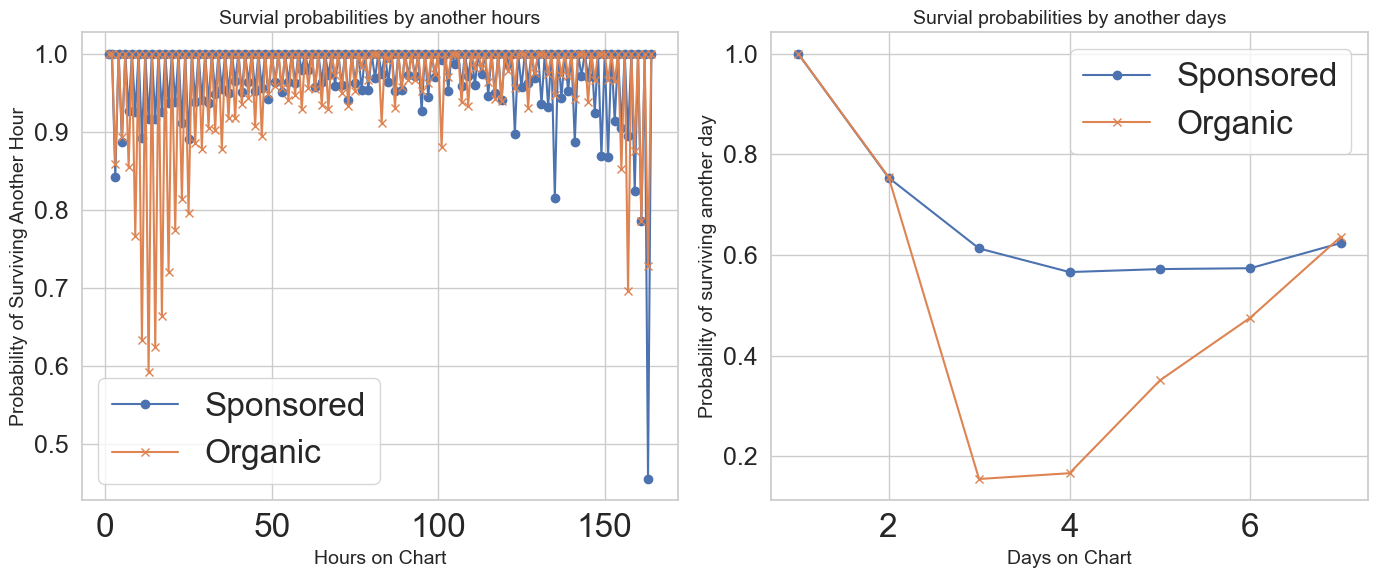

In [43]:
# apply to data
#hourly
sponsored_hour_probs = calculate_survival_prob(sponsored_data['survival_hours'])
organic_hour_probs = calculate_survival_prob(organic_data['survival_hours'])

#daily
sponsored_day_probs = calculate_survival_prob(sponsored_data['survival_days'])
organic_day_probs = calculate_survival_prob(organic_data['survival_days'])

# plot probabilities
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(sponsored_hour_probs)+1), sponsored_hour_probs, marker='o', label='Sponsored')
plt.plot(range(1, len(organic_hour_probs)+1), organic_hour_probs, marker='x', label='Organic')
plt.title('Survial probabilities by another hours')
plt.xlabel('Hours on Chart')
plt.ylabel('Probability of Surviving Another Hour')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(sponsored_day_probs)+1), sponsored_day_probs, marker='o', label='Sponsored')
plt.plot(range(1, len(organic_day_probs)+1), organic_day_probs, marker='x', label='Organic')
plt.title('Survial probabilities by another days')
plt.xlabel('Days on Chart')
plt.ylabel('Probability of surviving another day')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

4/ WEIBULL PHM

In [ ]:
# create feature input
features = [
    'initial_rank', 'price', 'reviews_count', 'rating', 
    'prime', 'popularity', 'discount', 'sales_badge', 'price_com',
    'sales_rank_main', 'sales_rank_sub'
]

In [48]:
# create separate model dataframes
# HOURLY
organic_hour_df = pd.concat([
    organic_data[['survival_hours', 'event']], 
    organic_data[features]
], axis=1)

sponsored_hour_df = pd.concat([
    sponsored_data[['survival_hours', 'event']], 
    sponsored_data[features]
], axis=1)

# DAILY
organic_day_df = pd.concat([
    organic_data[['survival_days', 'event']], 
    organic_data[features]
], axis=1)

sponsored_day_df = pd.concat([
    sponsored_data[['survival_days', 'event']], 
    sponsored_data[features]
], axis=1)

In [47]:
# fit weibull models

# HOURLY
waft_organic_hour = WeibullAFTFitter()
waft_organic_hour.fit(
    organic_hour_df,
    duration_col='survival_hours', 
    event_col='event'
)


waft_sponsored_hour = WeibullAFTFitter()
waft_sponsored_hour.fit(
    sponsored_hour_df,
    duration_col='survival_hours', 
    event_col='event'
)

# DAILY
waft_organic_day = WeibullAFTFitter()
waft_organic_day.fit(
    organic_day_df,
    duration_col='survival_days', 
    event_col='event'
)

waft_sponsored_day = WeibullAFTFitter()
waft_sponsored_day.fit(
    sponsored_day_df,
    duration_col='survival_days', 
    event_col='event'
)

<lifelines.WeibullAFTFitter: fitted with 3717 total observations, 0 right-censored observations>

In [54]:
# function to expo HR
def calculate_hazard_ratios(model, model_name):
    hazard_ratios = np.exp(-model.summary['coef'])
    hr_lower = np.exp(-model.summary['coef'] - 1.96 * model.summary['se(coef)'])
    hr_upper = np.exp(-model.summary['coef'] + 1.96 * model.summary['se(coef)'])
    
    # hazard ratio table
    hr_table = pd.DataFrame({
        'Feature': model.summary.index,
        'Hazard Ratio': hazard_ratios,
        'Lower 95% CI': hr_lower,
        'Upper 95% CI': hr_upper,
        'p-value': model.summary['p'],
        'Significant': model.summary['p'] < 0.05 #significant
    }).sort_values('Hazard Ratio', ascending=False)
    
    # percentage change in risk
    hr_table['% delta risk'] = (hr_table['Hazard Ratio'] - 1) * 100
    
    print(f"\nHazard Ratios for {model_name}:")
    print(hr_table)
    
    return hr_table

In [55]:
# apply for 4 models
hr_organic_hour = calculate_hazard_ratios(waft_organic_hour, "ORGANIC Hourly Survival")
hr_sponsored_hour = calculate_hazard_ratios(waft_sponsored_hour, "SPONSORED Hourly Survival")
hr_organic_day = calculate_hazard_ratios(waft_organic_day, "ORGANIC Daily Survival")
hr_sponsored_day = calculate_hazard_ratios(waft_sponsored_day, "SPONSORED Daily Survival")

# save csv to make table
hr_organic_hour.to_csv('hazard_ratios_organic_hours.csv', index=False)
hr_sponsored_hour.to_csv('hazard_ratios_sponsored_hours.csv', index=False)
hr_organic_day.to_csv('hazard_ratios_organic_days.csv', index=False)
hr_sponsored_day.to_csv('hazard_ratios_sponsored_days.csv', index=False)


Hazard Ratios for ORGANIC Hourly Survival:
                                            Feature  Hazard Ratio  \
param   covariate                                                   
lambda_ sales_rank_main  (lambda_, sales_rank_main)      1.041766   
        initial_rank        (lambda_, initial_rank)      1.003138   
        price_com              (lambda_, price_com)      1.001773   
        sales_rank_sub    (lambda_, sales_rank_sub)      0.999090   
        rating                    (lambda_, rating)      0.998961   
        discount                (lambda_, discount)      0.997138   
        reviews_count      (lambda_, reviews_count)      0.993448   
        price                      (lambda_, price)      0.970184   
        prime                      (lambda_, prime)      0.794780   
        popularity            (lambda_, popularity)      0.713678   
        sales_badge          (lambda_, sales_badge)      0.712387   
rho_    Intercept                 (rho_, Intercept)      0.